# Group Submission 2
---
## Team Members:
- Neo Meng Hwee
- Marc Tan
- Kanwar Angad Singh Dusaj
- Kim Chuong Hoang

---

In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Question
- Select at least four explanatory variables and perform the necessary transformations
so that they are useful in the model phase. You are encouraged to use more than four
variables. Investigate feature engineering techniques such as PCA and encoding
target variables using one-hot encoding
- Write a short paragraph about each technique investigated and show an
implementation of it in a Jupyter Notebook. Make sure to include references that
indicate where the ideas were sourced

### Generating Variables

- we will use the data from the **`data_day`** file generated from Submission 1 for this exercise



#### Importing Into DataFrame

In [5]:
import pandas as pd 
import numpy as np

data = pd.read_csv('data_day.csv', parse_dates=True, index_col='Date_Time')

#### Generating `close` variable

- period close price

In [6]:
data.drop(columns=['open', 'low', 'high', 'volume'], inplace=True)
data.head()

,close
Date_Time,
2013-09-01 17:00:00,1640.25
2013-09-01 17:05:00,1640.50
2013-09-01 17:10:00,1640.50
2013-09-01 17:15:00,1640.75
2013-09-01 17:20:00,1640.50


#### Generating `MACD` & `MACDSignal` variables

- Moving average convergence / divergence value
- MACD signal

In [8]:
data['EMA12'] = 0
data['EMA26'] = 0
data['EMA12'] = data['close'].ewm(min_periods=12,halflife=48,adjust=False).mean()
data['EMA26'] = data['close'].ewm(min_periods=26,halflife=104,adjust=False).mean()

data['MACD'] = (data['EMA12'] - data['EMA26'])
data['MACDsignal'] = data['MACD'].ewm(min_periods=9,halflife=36,adjust=False).mean()

data.drop(columns=['EMA12', 'EMA26'], inplace=True)
data.tail()

,close,MACD,MACDsignal
Date_Time,,,
2013-09-20 15:55:00,1704.50,-2.776568,-1.204074
2013-09-20 16:00:00,1704.75,-2.796478,-1.234441
2013-09-20 16:05:00,1704.75,-2.815707,-1.264596
2013-09-20 16:10:00,1704.00,-2.840036,-1.294640
2013-09-20 16:15:00,1703.75,-2.865510,-1.324596


#### Generating `pct_change` & `RSI` variables

- Percent change increase - `True / False`
- Relative strength index


In [9]:
data['pct_change'] = data['close'].pct_change()
data['pct_change'] = np.where(data['pct_change']>=0, 1, 0)
data['up'] = data['pct_change']
data['up'].fillna(0)
data['up'] = np.where(data['up']>0, 1, 0)
data['down'] = data['pct_change']
data['down'].fillna(0)
data['down'] = np.where(data['down']<=0, 1, 0)
data['RSIup'] = data['up'].ewm(min_periods=14,halflife=56,adjust=False).mean()
data['RSIdown'] = data['down'].ewm(min_periods=14,halflife=56,adjust=False).mean()
data['RS'] = data['RSIup'] / data['RSIdown']
data['RSI']= 100.0 - (100.0 / (1.0 + data['RS']))

data.drop(columns=['up', 'down', 'RSIup', 'RSIdown', 'RS'], inplace=True)
data.tail()

,close,MACD,MACDsignal,pct_change,RSI
Date_Time,,,,,
2013-09-20 15:55:00,1704.50,-2.776568,-1.204074,1,59.732475
2013-09-20 16:00:00,1704.75,-2.796478,-1.234441,1,60.227820
2013-09-20 16:05:00,1704.75,-2.815707,-1.264596,1,60.717071
2013-09-20 16:10:00,1704.00,-2.840036,-1.294640,0,59.970170
2013-09-20 16:15:00,1703.75,-2.865510,-1.324596,0,59.232456


#### Generating `close_autocorrel`, `pearsonr_close_MACD` and `pearsonr_close_RSI` variables

- Autocorrelation on period close price
- Correlation period close price vs MACD
- Correlation period close price vs RSI

In [10]:
from scipy.stats.stats import pearsonr

autocorrel = []
data['close_autocorrel'] = ''
data['pearsonr_close_MACD'] = ''
data['pearsonr_close_RSI'] = ''
data['quartile'] = 0
quarter = int(len(data) / 4)
for i in range (0,29):
    autocorrel.append('')
    data.iloc[i, data.columns.get_loc('quartile')] = int((i - 1) / quarter) + 1
for i in range(29,len(data)):
    seq1 = []
    seq2 = []
    seq3 = []
    quartile_val = int((i - 1) / quarter) + 1
    if (quartile_val == 5):
        quartile_val = 4
    data.iloc[i, data.columns.get_loc('quartile')] = quartile_val
    #print(i, quarter, quartile_val)
    for j in range (i-28,i):
        seq1.append(data['close'][j])
        seq2.append(data['MACD'][j])
        seq3.append(data['RSI'][j])
    autocorrel_series = pd.Series(seq1)
    autocorrel_val = autocorrel_series.autocorr(lag=1)
    data.iloc[i, data.columns.get_loc('close_autocorrel')] = autocorrel_val
    autocorrel.append(autocorrel_val)
    cross_correlation = pearsonr(seq1, seq2)
    data.iloc[i, data.columns.get_loc('pearsonr_close_MACD')] = cross_correlation[0]
    cross_correlation = pearsonr(seq1, seq3)
    data.iloc[i, data.columns.get_loc('pearsonr_close_RSI')] = cross_correlation[0]
    data.tail()

In [11]:
data.tail()

,close,MACD,MACDsignal,pct_change,RSI,close_autocorrel,pearsonr_close_MACD,pearsonr_close_RSI,quartile
Date_Time,,,,,,,,,
2013-09-20 15:55:00,1704.50,-2.776568,-1.204074,1,59.732475,0.88251,0.78316,0.884687,4
2013-09-20 16:00:00,1704.75,-2.796478,-1.234441,1,60.227820,0.866933,0.715724,0.869826,4
2013-09-20 16:05:00,1704.75,-2.815707,-1.264596,1,60.717071,0.871859,0.631796,0.869516,4
2013-09-20 16:10:00,1704.00,-2.840036,-1.294640,0,59.970170,0.869695,0.57301,0.860855,4
2013-09-20 16:15:00,1703.75,-2.865510,-1.324596,0,59.232456,0.86105,0.535243,0.84871,4


#### Calculating Target Variable `quartile`

- The target variable will be quartiles of period close price
- $1$ represent the lowest quartile of close prices and $4$ is the highest

### Performing Feature Engineering on Explanatory Variables

#### Formatting for using `sklearn`

- We remove the index column and headings to utilize the PCA & LDA classes from **`sklearn`** library

In [13]:
data_train = data.dropna().values
data_train

array([[1641.5, 0.3360701487320057, 0.1539812796951609, ...,
        0.5034863275725053, 0.6516834576010556, 1],
       [1641.0, 0.33406957853594577, 0.15741554776590888, ...,
        0.32719558344573674, 0.4929144586796308, 1],
       [1640.75, 0.3301554521833623, 0.16070968259922971, ...,
        0.09351353017558908, 0.2797874751892988, 1],
       ...,
       [1704.75, -2.815706736150787, -1.2645959977957417, ...,
        0.6317961247781377, 0.869516439001569, 4],
       [1704.0, -2.8400360498021655, -1.2946395014703842, ...,
        0.573010043933211, 0.8608551814768564, 4],
       [1703.75, -2.8655103129528925, -1.3245958701288159, ...,
        0.5352427987825941, 0.8487103906824096, 4]], dtype=object)

#### Using Principal Component Analysis (PCA)

- PCA is a technique for reducing the dimensionality of data
- PCA can be viewed as a projection method where data with ***m***-columns (**features**) is _projected_ into a subspace with $\leq$ ***m*** columns whilst retaining the essence of the original data
- We consider the case where number of components to $3$
- the **`PCA`** class is fitted to dataset **`data_train`** and projected into a subspace with $3$ dimensions by calling the **`fit_transform()`** function
- we can access the % of variance explained by each component via the **`explained_variance_ratio_`** attribute of the **`PCA`** class

$\rightarrow$ We display the percentage of variance explained on a bar chart as shown below.

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#train_labels = data_train[:,1]
train_labels = data_train[:,-1]
train_classes = list(set(train_labels))
train_classes = np.array(train_classes, dtype=int)
train_labels = np.array(train_labels, dtype=int)
#data_train = data_train[:, 1:]
data_train = data_train[:, :-1]


pca = PCA(n_components=3)
pca.fit_transform(data_train)

print("Percentage of variance explained by each of the selected components:")
print(pca.explained_variance_ratio_) 

Percentage of variance explained by each of the selected components:
[0.95458323 0.03480325 0.00907758]


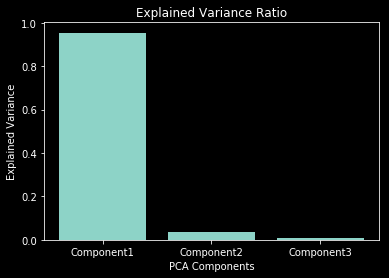

In [19]:
plt.style.use('dark_background')

plt.bar(['Component1','Component2','Component3'], pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('PCA Components')
plt.title('Explained Variance Ratio')
plt.show()

- Since the 1st 2 principal components explain for $\geq 99\%$ of variance, we store the 1st 2 principal components along with the target variable and present it below



In [20]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_train)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

classes = pd.DataFrame(train_labels)
classes['classes'] = classes
classes.drop(columns=[0], inplace=True)

finalDf = pd.concat([principalDf, classes[['classes']]], axis = 1)
finalDf.head()

,PC1,PC2,classes
0,-36.643519,30.158375,1
1,-37.150789,30.553816,1
2,-37.408313,30.949526,1
3,-37.143704,30.117175,1
4,-37.128856,29.302182,1


In [21]:
finalDf.tail()

,PC1,PC2,classes
4044,26.650694,5.762915,4
4045,26.908004,5.278870,4
4046,26.915460,4.794994,4
4047,26.151035,5.535738,4
4048,25.886153,6.266565,4


- Visualizing the PCA components

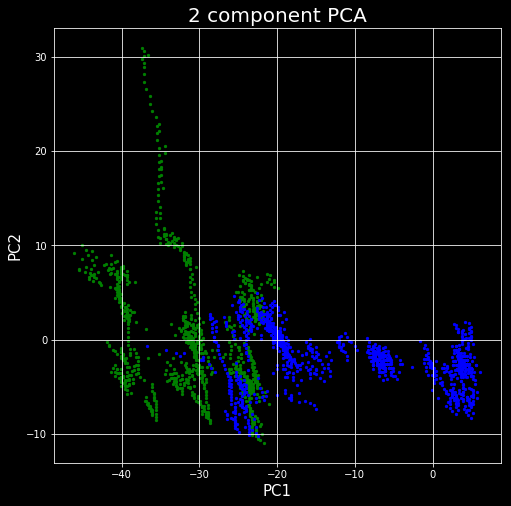

In [22]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
classes = [0,1,2]
colors = ['r', 'g', 'b']
for classes, color in zip(classes,colors):
    indicesToKeep = finalDf['classes'] == classes
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 5)
#ax.legend(classes)
ax.grid()

#### Using Linear Discriminant Analysis (LDA)

- Linear Discriminant Analysis **(LDA)** is another method for reducing the dimensionality of data
- The LDA approach is very similar to PCA **except** that in addition to finding the component axes that maximize the variance of our data, we are also interested in the axes that maximize the seperation between the multiple classes of LDA 
- The goal of LDA is to project a dataset onto a lower-dimensional space **WITH** good **class separability** to achieve 2 main purposes:
    - Avoid Overfitting
    - Reduce Computational Costs

---
- **Steps for LDA include:**
    1. Compute $d$-dimensional mean vectors for different classes from the dataset, where $d$ is the dimension of feature space
    2. Compute in-between class and with-in class scatter matrices
    3. Compute eigen vectors and corresponding eigen values for the scatter matrices
    4. Choose $k$ eigen vectors corresponding to top $k$ eigen values to form a transformation matrix of dimension $d \times k$
    5. Transform the $d$-dimensional feature space $X$ to $k$-dimensional feature space $X_{LDA}$ via the transformation matrix
---
- We will directly apply the **`LinearDiscriminantAnalysis`** class in the **`sklearn.discriminant_analysis`** library. 
- we can set the number of components in `n_components=3`
- the **`lda`** class is fitted to dataset **`data_train`** and projected into a subspace with $3$ dimensions by calling the **`fit_transform()`** function
- we can access the % of variance explained by each component via the **`explained_variance_ratio_`** attribute of the **`lda`** class
- We display the percentage of variance explained on a bar chart as shown below.

Percentage of variance explained by each of the selected components:
[0.95458323 0.03480325]


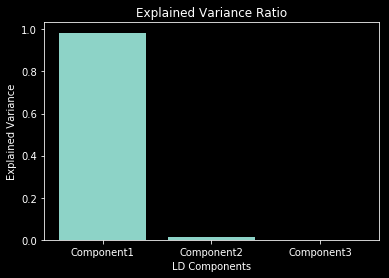

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

data_train = data.dropna().values
train_labels = data_train[:,-1]
train_classes = list(set(train_labels))
train_classes = np.array(train_classes, dtype=int)
train_labels = np.array(train_labels, dtype=int)
data_train = data_train[:, :-1]

lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit_transform(data_train, train_labels)

print("Percentage of variance explained by each of the selected components:")
print(pca.explained_variance_ratio_) 

plt.bar(['Component1','Component2','Component3'], lda.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('LD Components')
plt.title('Explained Variance Ratio')
plt.show()

- Again since the 1st 2 principal components explain for $≥99\%$  of variance, we store the 1st 2 principal components along with the target variable

In [24]:
lda = LinearDiscriminantAnalysis (n_components=2)
principalComponents = lda.fit_transform(data_train, train_labels)
principalDf = pd.DataFrame(data = principalComponents, columns = ['LD1', 'LD2'])

classes = pd.DataFrame(train_labels)
classes['classes'] = classes
classes.drop(columns=[0], inplace=True)

finalDf = pd.concat([principalDf, classes[['classes']]], axis = 1)
finalDf.head()

,LD1,LD2,classes
0,-5.119080,6.034633,1
1,-5.248738,6.080011,1
2,-5.374085,6.096755,1
3,-5.484822,5.941345,1
4,-5.544466,5.734836,1


In [25]:
finalDf.tail()

,LD1,LD2,classes
4044,6.678709,1.631387,4
4045,6.728724,1.571268,4
4046,6.735514,1.521850,4
4047,6.691879,1.627462,4
4048,6.660335,1.784037,4


- Visualizing the LDA components

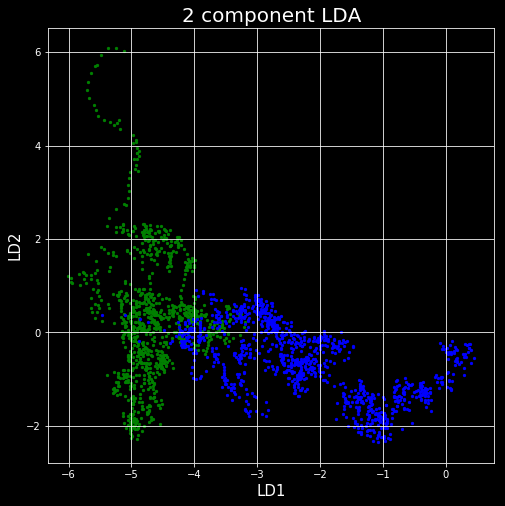

In [26]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('LD1', fontsize = 15)
ax.set_ylabel('LD2', fontsize = 15)
ax.set_title('2 component LDA', fontsize = 20)
classes = [0,1,2]
colors = ['r', 'g', 'b']
for classes, color in zip(classes,colors):
    indicesToKeep = finalDf['classes'] == classes
    ax.scatter(finalDf.loc[indicesToKeep, 'LD1']
               , finalDf.loc[indicesToKeep, 'LD2']
               , c = color
               , s = 5)
#ax.legend(classes)
ax.grid()